In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
from collections import Counter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from urllib import request
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from ppxf.ppxf_util import log_rebin
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
import csv
from scipy import ndimage
import glob
from time import time 
from astropy.wcs import WCS

In [2]:
input_cubes='/home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/inputs/'
output_cubes='/home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/'
spec_sloan='/home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/specsloan.txt'

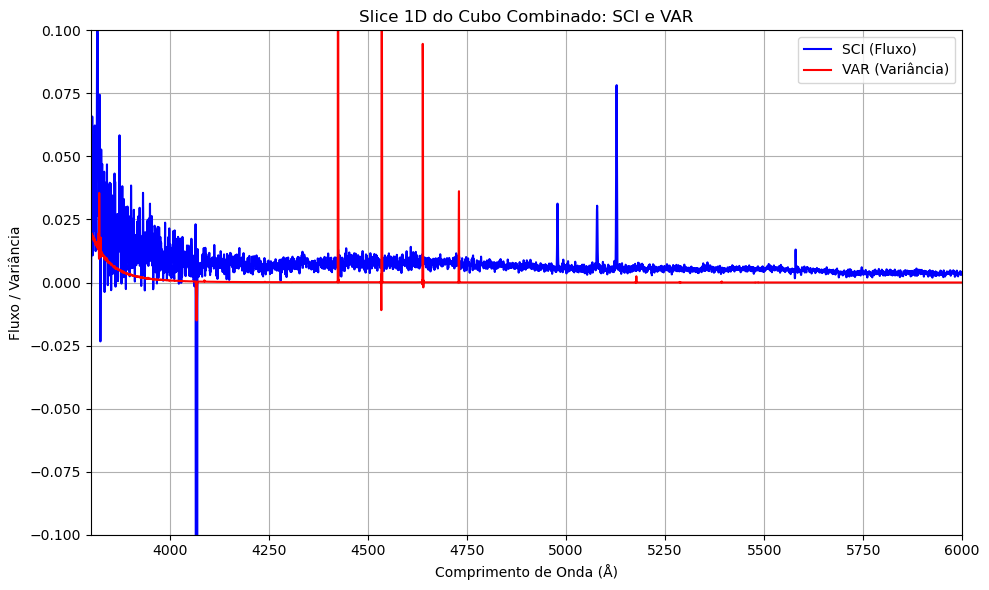

In [7]:
# Função para carregar cubos de duas extensões e calcular array_lambda
def load_cube(filename):
    hdul = fits.open(filename)
    
    # Carregar as duas extensões
    cubo_ext1 = hdul[1].data  # Extensão 1
    cubo_ext2 = hdul[2].data  # Extensão 2
    hdr = hdul[1].header
    
    # Carregar informações do cabeçalho
    wav0 = hdr['CRVAL3']
    wavdisp = hdr['CD3_3']
    pix0 = hdr['CRPIX3']
    delta_lambda = wavdisp
    array_lambda = -pix0 * wavdisp + wav0 + delta_lambda * np.arange(0, cubo_ext1.shape[0])
    
    hdul.close()
    
    return cubo_ext1, cubo_ext2, array_lambda, wavdisp

# Função para interpolar cubos usando CubicSpline
def interpolate_cube(cubo, array_lambda, array_lambda_comb):
    cubo_mod = np.zeros((len(array_lambda_comb), cubo.shape[1], cubo.shape[2]))
    for i in range(cubo.shape[1]):
        for j in range(cubo.shape[2]):
            flux = cubo[:, i, j]
            csf = CubicSpline(array_lambda, flux)
            for k in range(len(array_lambda_comb)):
                if (array_lambda_comb[k] < array_lambda[0]) or (array_lambda_comb[k] > array_lambda[-1]):
                    cubo_mod[k, i, j] = 0.
                else:
                    cubo_mod[k, i, j] = csf(array_lambda_comb[k])
    return cubo_mod


cubo_ext1_480, cubo_ext2_480, array_lambda_480, wavdisp = load_cube(input_cubes + '480_3D.fits')
cubo_ext1_490, cubo_ext2_490, array_lambda_490, _ = load_cube(input_cubes + '490_3D.fits')
cubo_ext1_500, cubo_ext2_500, array_lambda_500, _ = load_cube(input_cubes + '500_3D.fits')
cubo_ext1_510, cubo_ext2_510, array_lambda_510, _ = load_cube(input_cubes + '510_3D.fits')

# Definir array_lambda_comb
lmin = min(array_lambda_480[0], array_lambda_490[0], array_lambda_500[0], array_lambda_510[0])
lmax = max(array_lambda_480[-1], array_lambda_490[-1], array_lambda_500[-1], array_lambda_510[-1])
npix = int((lmax - lmin) / wavdisp)
array_lambda_comb = lmin + wavdisp * np.arange(0, npix)

# Interpolando as extensões dos cubos
cubomod_ext1_480 = interpolate_cube(cubo_ext1_480, array_lambda_480, array_lambda_comb)
cubomod_ext2_480 = interpolate_cube(cubo_ext2_480, array_lambda_480, array_lambda_comb)

cubomod_ext1_490 = interpolate_cube(cubo_ext1_490, array_lambda_490, array_lambda_comb)
cubomod_ext2_490 = interpolate_cube(cubo_ext2_490, array_lambda_490, array_lambda_comb)

cubomod_ext1_500 = interpolate_cube(cubo_ext1_500, array_lambda_500, array_lambda_comb)
cubomod_ext2_500 = interpolate_cube(cubo_ext2_500, array_lambda_500, array_lambda_comb)

cubomod_ext1_510 = interpolate_cube(cubo_ext1_510, array_lambda_510, array_lambda_comb)
cubomod_ext2_510 = interpolate_cube(cubo_ext2_510, array_lambda_510, array_lambda_comb)

# Combinação dos cubos para as duas extensões
def combine_cubes(cubos_mod, array_lambdas, array_lambda_comb):
    cubofinal = np.zeros((len(array_lambda_comb), cubos_mod[0].shape[1], cubos_mod[0].shape[2]))
    
    for i in range(cubos_mod[0].shape[1]):
        for j in range(cubos_mod[0].shape[2]):
            for k in range(len(array_lambda_comb)):
                sum_flux = 0
                count_flux = 0
                for cubo_mod, array_lambda in zip(cubos_mod, array_lambdas):
                    if array_lambda[0] <= array_lambda_comb[k] <= array_lambda[-1]:
                        sum_flux += cubo_mod[k, i, j]
                        count_flux += 1
                if count_flux > 0:
                    cubofinal[k, i, j] = sum_flux / count_flux
    return cubofinal

# Combinar as duas extensões para cada cubo
cubofinal_ext1 = combine_cubes([cubomod_ext1_480, cubomod_ext1_490, cubomod_ext1_500, cubomod_ext1_510], 
                               [array_lambda_480, array_lambda_490, array_lambda_500, array_lambda_510], array_lambda_comb)

cubofinal_ext2 = combine_cubes([cubomod_ext2_480, cubomod_ext2_490, cubomod_ext2_500, cubomod_ext2_510], 
                               [array_lambda_480, array_lambda_490, array_lambda_500, array_lambda_510], array_lambda_comb)

# Salvando o cubo final com as duas extensões
primary_hdu = fits.PrimaryHDU(cubofinal_ext1)
secondary_hdu = fits.ImageHDU(cubofinal_ext2)

# Atualizando cabeçalhos
primary_hdu.header['COMMENT'] = "Cubo combinado SCI"
primary_hdu.header['CRVAL3'] = array_lambda_comb[0]  
primary_hdu.header['CRPIX3'] = 1  
primary_hdu.header['CDELT3'] = array_lambda_comb[1] - array_lambda_comb[0]

secondary_hdu.header['COMMENT'] = "Cubo combinado VAR"
secondary_hdu.header['CRVAL3'] = array_lambda_comb[0]  
secondary_hdu.header['CRPIX3'] = 1  
secondary_hdu.header['CDELT3'] = array_lambda_comb[1] - array_lambda_comb[0]

# Escrevendo o arquivo final com ambas as extensões combinadas
hdulist = fits.HDUList([primary_hdu, secondary_hdu])
hdulist.writeto(output_cubes + 'cubocombinado_extensoesB.fits', overwrite=True)

# PLOT #
# Escolha um pixel (x, y) para extrair o espectro
x, y = 17, 24

# Extrai o espectro (slice) ao longo do eixo de comprimento de onda
sci_slice = cubofinal_ext1[:, y, x]  # SCI
var_slice = cubofinal_ext2[:, y, x]  # VAR

# Se 'var_slice' for variância, você pode converter para erro (desvio padrão):
# err_slice = np.sqrt(var_slice)

# Plotando SCI e VAR no mesmo gráfico
plt.figure(figsize=(10, 6))
plt.plot(array_lambda_comb, sci_slice, label='SCI (Fluxo)', color='blue')
plt.plot(array_lambda_comb, var_slice, label='VAR (Variância)', color='red')
plt.xlabel('Comprimento de Onda (Å)')
plt.xlim(3800,6000)
plt.ylabel('Fluxo / Variância')
plt.ylim(-0.1,0.1)
plt.title('Slice 1D do Cubo Combinado: SCI e VAR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

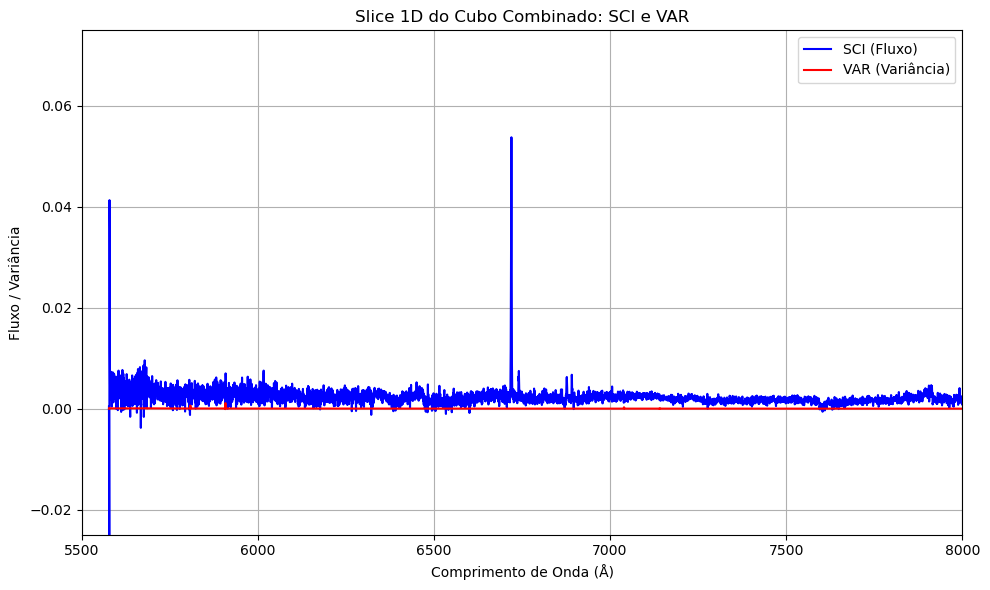

In [10]:
# Função para carregar cubos de duas extensões e calcular array_lambda
def load_cube(filename):
    hdul = fits.open(filename)
    
    # Carregar as duas extensões
    cubo_ext1 = hdul[1].data  # Extensão 1
    cubo_ext2 = hdul[2].data  # Extensão 2
    hdr = hdul[1].header
    
    # Carregar informações do cabeçalho
    wav0 = hdr['CRVAL3']
    wavdisp = hdr['CD3_3']
    pix0 = hdr['CRPIX3']
    delta_lambda = wavdisp
    array_lambda = -pix0 * wavdisp + wav0 + delta_lambda * np.arange(0, cubo_ext1.shape[0])
    
    hdul.close()
    
    return cubo_ext1, cubo_ext2, array_lambda, wavdisp

# Função para interpolar cubos usando CubicSpline
def interpolate_cube(cubo, array_lambda, array_lambda_comb):
    cubo_mod = np.zeros((len(array_lambda_comb), cubo.shape[1], cubo.shape[2]))
    for i in range(cubo.shape[1]):
        for j in range(cubo.shape[2]):
            flux = cubo[:, i, j]
            csf = CubicSpline(array_lambda, flux)
            for k in range(len(array_lambda_comb)):
                if (array_lambda_comb[k] < array_lambda[0]) or (array_lambda_comb[k] > array_lambda[-1]):
                    cubo_mod[k, i, j] = 0.
                else:
                    cubo_mod[k, i, j] = csf(array_lambda_comb[k])
    return cubo_mod


#cubo_ext1_665, cubo_ext2_665, array_lambda_665, wavdisp = load_cube(input_cubes + '665_3D.fits')
cubo_ext1_675, cubo_ext2_675, array_lambda_675, _ = load_cube(input_cubes + '675_3D.fits')
cubo_ext1_685, cubo_ext2_685, array_lambda_685, _ = load_cube(input_cubes + '685_3D.fits')

# Definir array_lambda_comb
lmin = min(array_lambda_675[0], array_lambda_685[0])
lmax = max(array_lambda_675[-1], array_lambda_685[-1])
npix = int((lmax - lmin) / wavdisp)
array_lambda_comb = lmin + wavdisp * np.arange(0, npix)

# Interpolando as extensões dos cubos
#cubomod_ext1_665 = interpolate_cube(cubo_ext1_665, array_lambda_665, array_lambda_comb)
#cubomod_ext2_665 = interpolate_cube(cubo_ext2_665, array_lambda_665, array_lambda_comb)

cubomod_ext1_675 = interpolate_cube(cubo_ext1_675, array_lambda_675, array_lambda_comb)
cubomod_ext2_675 = interpolate_cube(cubo_ext2_675, array_lambda_675, array_lambda_comb)

cubomod_ext1_685 = interpolate_cube(cubo_ext1_685, array_lambda_685, array_lambda_comb)
cubomod_ext2_685 = interpolate_cube(cubo_ext2_685, array_lambda_685, array_lambda_comb)


# Combinação dos cubos para as duas extensões
def combine_cubes(cubos_mod, array_lambdas, array_lambda_comb):
    cubofinal = np.zeros((len(array_lambda_comb), cubos_mod[0].shape[1], cubos_mod[0].shape[2]))
    
    for i in range(cubos_mod[0].shape[1]):
        for j in range(cubos_mod[0].shape[2]):
            for k in range(len(array_lambda_comb)):
                sum_flux = 0
                count_flux = 0
                for cubo_mod, array_lambda in zip(cubos_mod, array_lambdas):
                    if array_lambda[0] <= array_lambda_comb[k] <= array_lambda[-1]:
                        sum_flux += cubo_mod[k, i, j]
                        count_flux += 1
                if count_flux > 0:
                    cubofinal[k, i, j] = sum_flux / count_flux
    return cubofinal

# Combinar as duas extensões para cada cubo
cubofinal_ext1 = combine_cubes([cubomod_ext1_675, cubomod_ext1_685], 
                               [array_lambda_675, array_lambda_685], array_lambda_comb)

cubofinal_ext2 = combine_cubes([cubomod_ext2_675, cubomod_ext2_685], 
                               [array_lambda_675, array_lambda_685], array_lambda_comb)

# Salvando o cubo final com as duas extensões
primary_hdu = fits.PrimaryHDU(cubofinal_ext1)
secondary_hdu = fits.ImageHDU(cubofinal_ext2)

# Atualizando cabeçalhos
primary_hdu.header['COMMENT'] = "Cubo combinado SCI"
primary_hdu.header['CRVAL3'] = array_lambda_comb[0]  
primary_hdu.header['CRPIX3'] = 1  
primary_hdu.header['CDELT3'] = array_lambda_comb[1] - array_lambda_comb[0]

secondary_hdu.header['COMMENT'] = "Cubo combinado VAR"
secondary_hdu.header['CRVAL3'] = array_lambda_comb[0]  
secondary_hdu.header['CRPIX3'] = 1  
secondary_hdu.header['CDELT3'] = array_lambda_comb[1] - array_lambda_comb[0]

# Escrevendo o arquivo final com ambas as extensões combinadas
hdulist = fits.HDUList([primary_hdu, secondary_hdu])
hdulist.writeto(output_cubes + 'cubocombinado_extensoesR.fits', overwrite=True)

# PLOT #
# Escolha um pixel (x, y) para extrair o espectro
x, y = 17, 24

# Extrai o espectro (slice) ao longo do eixo de comprimento de onda
sci_slice = cubofinal_ext1[:, y, x]  # SCI
var_slice = cubofinal_ext2[:, y, x]  # VAR

# Se 'var_slice' for variância, você pode converter para erro (desvio padrão):
# err_slice = np.sqrt(var_slice)

# Plotando SCI e VAR no mesmo gráfico
plt.figure(figsize=(10, 6))
plt.plot(array_lambda_comb, sci_slice, label='SCI (Fluxo)', color='blue')
plt.plot(array_lambda_comb, var_slice, label='VAR (Variância)', color='red')
plt.xlabel('Comprimento de Onda (Å)')
plt.xlim(5500,8000)
plt.ylabel('Fluxo / Variância')
plt.ylim(-0.025,0.075)
plt.title('Slice 1D do Cubo Combinado: SCI e VAR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Filename: /home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/restframeB.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (33, 49, 6894)   float64   
  1                1 ImageHDU        12   (33, 49, 6894)   float64   
    wav      flux     col3  col4
0  3718  44.79757  5.92771     0
1  3719  39.73226  5.72891     0
2  3720  41.75132  5.64547     0
3  3721  43.11808  5.62639     0
4  3722  40.01158  5.71017     0
Index(['wav', 'flux', 'col3', 'col4'], dtype='object')
wav       int64
flux    float64
col3    float64
col4      int64
dtype: object
[ 3718.  3719.  3720. ... 10497. 10498. 10499.]


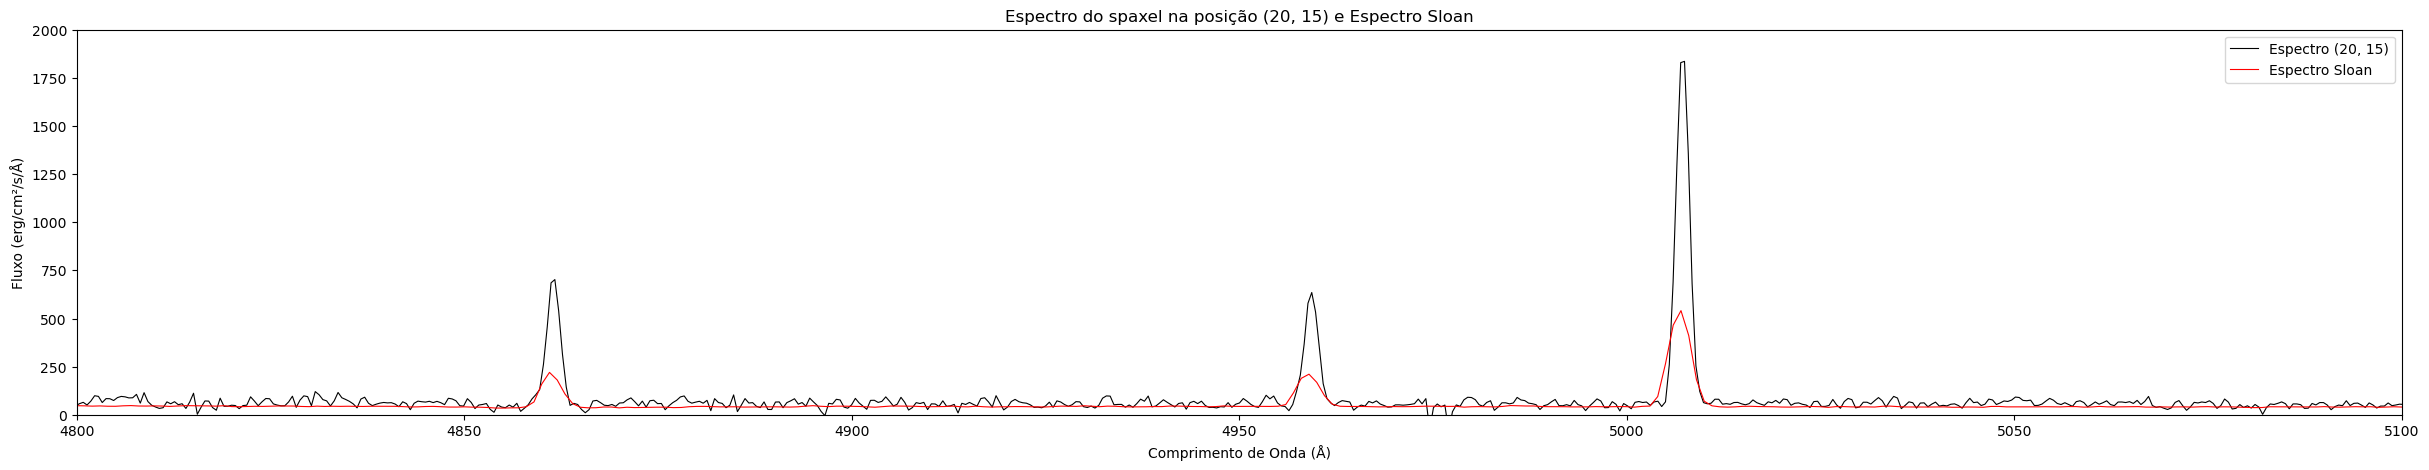

In [34]:
hdul = fits.open(output_cubes+'cubocombinado_extensoesB.fits')
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) # Fluxos na extensão SCI
var_array = np.array(var_data) # Fluxos na extensão VAR
z_dim, y_dim, x_dim = sci_array.shape
wavelengths_obs = lambda_start + delta_lambda * np.arange(z_dim)

v_radial = 7224  # Velocidade radial central em km/s
c = 300000  # Velocidade da luz em km/s
wavelengths_corr = wavelengths_obs / (1 + (v_radial / c))


header['CRVAL3'] = wavelengths_corr[0]  # Novo comprimento de onda inicial
header['CDELT3'] = wavelengths_corr[1] - wavelengths_corr[0]  # Novo delta lambda
hdu_sci = fits.PrimaryHDU(data=sci_array, header=header)
hdu_var = fits.ImageHDU(data=var_array, header=header)  # Mantendo o VAR inalterado
hdul_corrigido = fits.HDUList([hdu_sci, hdu_var])
hdul_corrigido.writeto(output_cubes+'restframeB.fits', overwrite=True)

#COMPARAÇÃO COM O ESPECTRO DO SDSS
hdul = fits.open(output_cubes+'restframeB.fits')
hdul.info()
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) 
z_dim, y_dim, x_dim = sci_array.shape
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)
x, y = 20, 15 
spectrum = sci_array[:, y, x]
spectrum=20000*spectrum

data_sloan=pd.read_csv(spec_sloan, sep='\s+',engine='python', header=0)
data_sloan.columns = ['wav', 'flux', 'col3', 'col4']
print(data_sloan.head())
print(data_sloan.columns)
print(data_sloan.dtypes)
wav_sloan = data_sloan['wav'].astype(float).values
flux = data_sloan['flux'].astype(float).values


print(wav_sloan)
plt.figure(figsize=(30, 5))
plt.plot(wavelengths, spectrum, color='black', linewidth=0.8, label=f'Espectro ({x}, {y})')
plt.plot(wav_sloan, flux, color='red', linewidth=0.8, label='Espectro Sloan')
plt.title(f'Espectro do spaxel na posição ({x}, {y}) e Espectro Sloan')
plt.xlabel('Comprimento de Onda (Å)')
plt.xlim(4800,5100)
plt.ylabel('Fluxo (erg/cm²/s/Å)')
plt.ylim(-0.01,2000)
plt.legend()
plt.show()



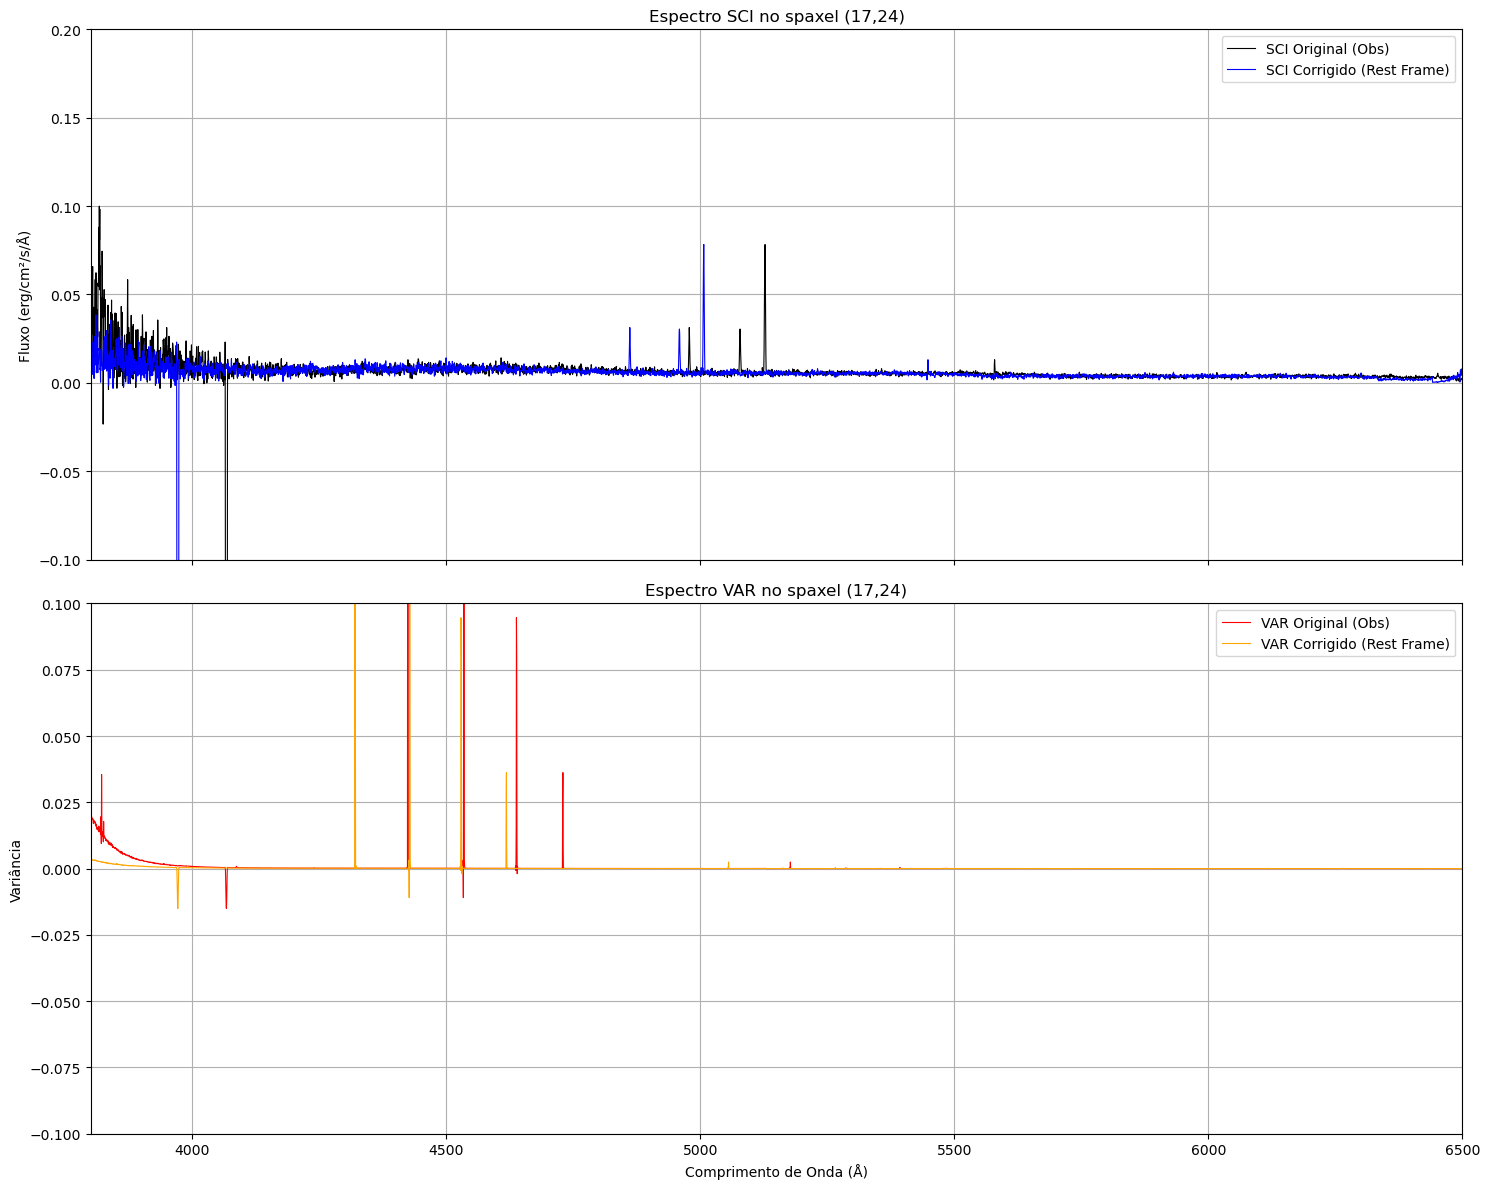

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- 1. Ler o cubo original (antes da correção) ---
orig_file = output_cubes + 'cubocombinado_extensoesB.fits'
hdul_orig = fits.open(orig_file)
header_orig = hdul_orig[0].header  
sci_orig = hdul_orig[0].data   # Extensão SCI original
var_orig = hdul_orig[1].data   # Extensão VAR original
hdul_orig.close()

lambda_start_orig = header_orig['CRVAL3']
delta_lambda_orig = header_orig['CDELT3']
z_dim, y_dim, x_dim = sci_orig.shape
wavelengths_obs = lambda_start_orig + delta_lambda_orig * np.arange(z_dim)

# --- 2. Ler o cubo corrigido (rest frame) ---
rest_file = output_cubes + 'restframeB.fits'
hdul_corr = fits.open(rest_file)
header_corr = hdul_corr[0].header  
sci_corr = hdul_corr[0].data   # Extensão SCI corrigida
var_corr = hdul_corr[1].data    # Extensão VAR corrigida
hdul_corr.close()

lambda_start_corr = header_corr['CRVAL3']
delta_lambda_corr = header_corr['CDELT3']
z_dim_corr, _, _ = sci_corr.shape
wavelengths_corr = lambda_start_corr + delta_lambda_corr * np.arange(z_dim_corr)

# --- 3. Selecionar um spaxel específico (ex: x = 20, y = 15) ---
x, y = 17, 24

# Extraindo o espectro (SCI) e a variância (VAR) para o spaxel escolhido:
spec_orig_sci = sci_orig[:, y, x]
var_spec_orig = var_orig[:, y, x]

spec_corr_sci = sci_corr[:, y, x]
var_spec_corr = var_corr[:, y, x]

# Se no seu código original você aplicava um fator de escala (por exemplo, multiplicava por 20000 para melhor visualização do SCI)

spec_orig_plot =  spec_orig_sci
spec_corr_plot =  spec_corr_sci

# --- 4. Plotar os espectros para comparação visual ---
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot para a extensão SCI:
axs[0].plot(wavelengths_obs, spec_orig_plot, color='black', lw=0.8, label='SCI Original (Obs)')
axs[0].plot(wavelengths_corr, spec_corr_plot, color='blue', lw=0.8, label='SCI Corrigido (Rest Frame)')
axs[0].set_ylabel('Fluxo (erg/cm²/s/Å)')
axs[0].set_title(f'Espectro SCI no spaxel ({x},{y})')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim(4800, 5100)
axs[0].set_ylim(-0.1,0.2)

# Plot para a extensão VAR:
axs[1].plot(wavelengths_obs, var_spec_orig, color='red', lw=0.8, label='VAR Original (Obs)')
axs[1].plot(wavelengths_corr, var_spec_corr, color='orange', lw=0.8, label='VAR Corrigido (Rest Frame)')
axs[1].set_xlabel('Comprimento de Onda (Å)')
axs[1].set_ylabel('Variância')
axs[1].set_title(f'Espectro VAR no spaxel ({x},{y})')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlim(3800, 6500)
axs[1].set_ylim(-0.1,0.1)

plt.tight_layout()
plt.show()


Filename: /home/sabrinadopico/Área de trabalho/análise3866/1-Cubesprep/restframeR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (33, 49, 4860)   float64   
  1                1 ImageHDU        12   (33, 49, 4860)   float64   
    wav      flux     col3  col4
0  3718  44.79757  5.92771     0
1  3719  39.73226  5.72891     0
2  3720  41.75132  5.64547     0
3  3721  43.11808  5.62639     0
4  3722  40.01158  5.71017     0
Index(['wav', 'flux', 'col3', 'col4'], dtype='object')
wav       int64
flux    float64
col3    float64
col4      int64
dtype: object
[ 3718.  3719.  3720. ... 10497. 10498. 10499.]


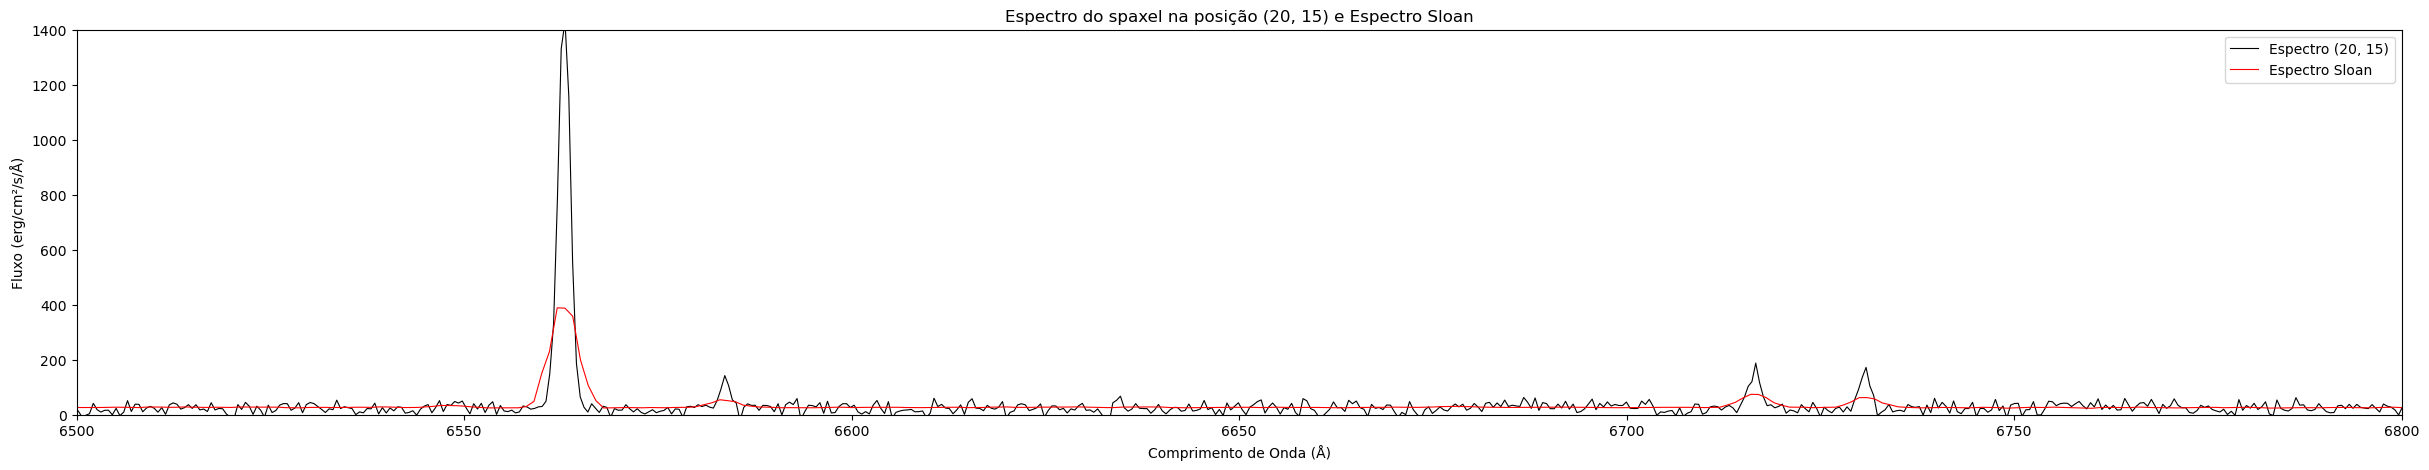

In [14]:
hdul = fits.open(output_cubes+'cubocombinado_extensoesR.fits')
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) # Fluxos na extensão SCI
var_array = np.array(var_data) # Fluxos na extensão VAR
z_dim, y_dim, x_dim = sci_array.shape
wavelengths_obs = lambda_start + delta_lambda * np.arange(z_dim)

v_radial = 7159.58  # Velocidade radial central em km/s
c = 299792  # Velocidade da luz em km/s
wavelengths_corr = wavelengths_obs / (1 + (v_radial / c))


header['CRVAL3'] = wavelengths_corr[0]  # Novo comprimento de onda inicial
header['CDELT3'] = wavelengths_corr[1] - wavelengths_corr[0]  # Novo delta lambda
hdu_sci = fits.PrimaryHDU(data=sci_array, header=header)
hdu_var = fits.ImageHDU(data=var_array, header=header)  # Mantendo o VAR inalterado
hdul_corrigido = fits.HDUList([hdu_sci, hdu_var])
hdul_corrigido.writeto(output_cubes+'restframeR.fits', overwrite=True)
#COMPARAÇÃO COM O ESPECTRO DO SDSS
hdul = fits.open(output_cubes+'restframeR.fits')
hdul.info()
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) 
z_dim, y_dim, x_dim = sci_array.shape
#print(z_dim, y_dim, x_dim)
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)
x, y = 20, 15 
spectrum = sci_array[:, y, x]
spectrum=20000*spectrum

data_sloan=pd.read_csv(spec_sloan, sep='\s+',engine='python', header=0)
data_sloan.columns = ['wav', 'flux', 'col3', 'col4']
print(data_sloan.head())
print(data_sloan.columns)
print(data_sloan.dtypes)
wav_sloan = data_sloan['wav'].astype(float).values
flux = data_sloan['flux'].astype(float).values


print(wav_sloan)
plt.figure(figsize=(30, 5))
plt.plot(wavelengths, spectrum, color='black', linewidth=0.8, label=f'Espectro ({x}, {y})')
plt.plot(wav_sloan, flux, color='red', linewidth=0.8, label='Espectro Sloan')
plt.title(f'Espectro do spaxel na posição ({x}, {y}) e Espectro Sloan')
plt.xlabel('Comprimento de Onda (Å)')
plt.xlim(6500,6800)
plt.ylabel('Fluxo (erg/cm²/s/Å)')
plt.ylim(-0.01,1400)
plt.legend()
plt.show()

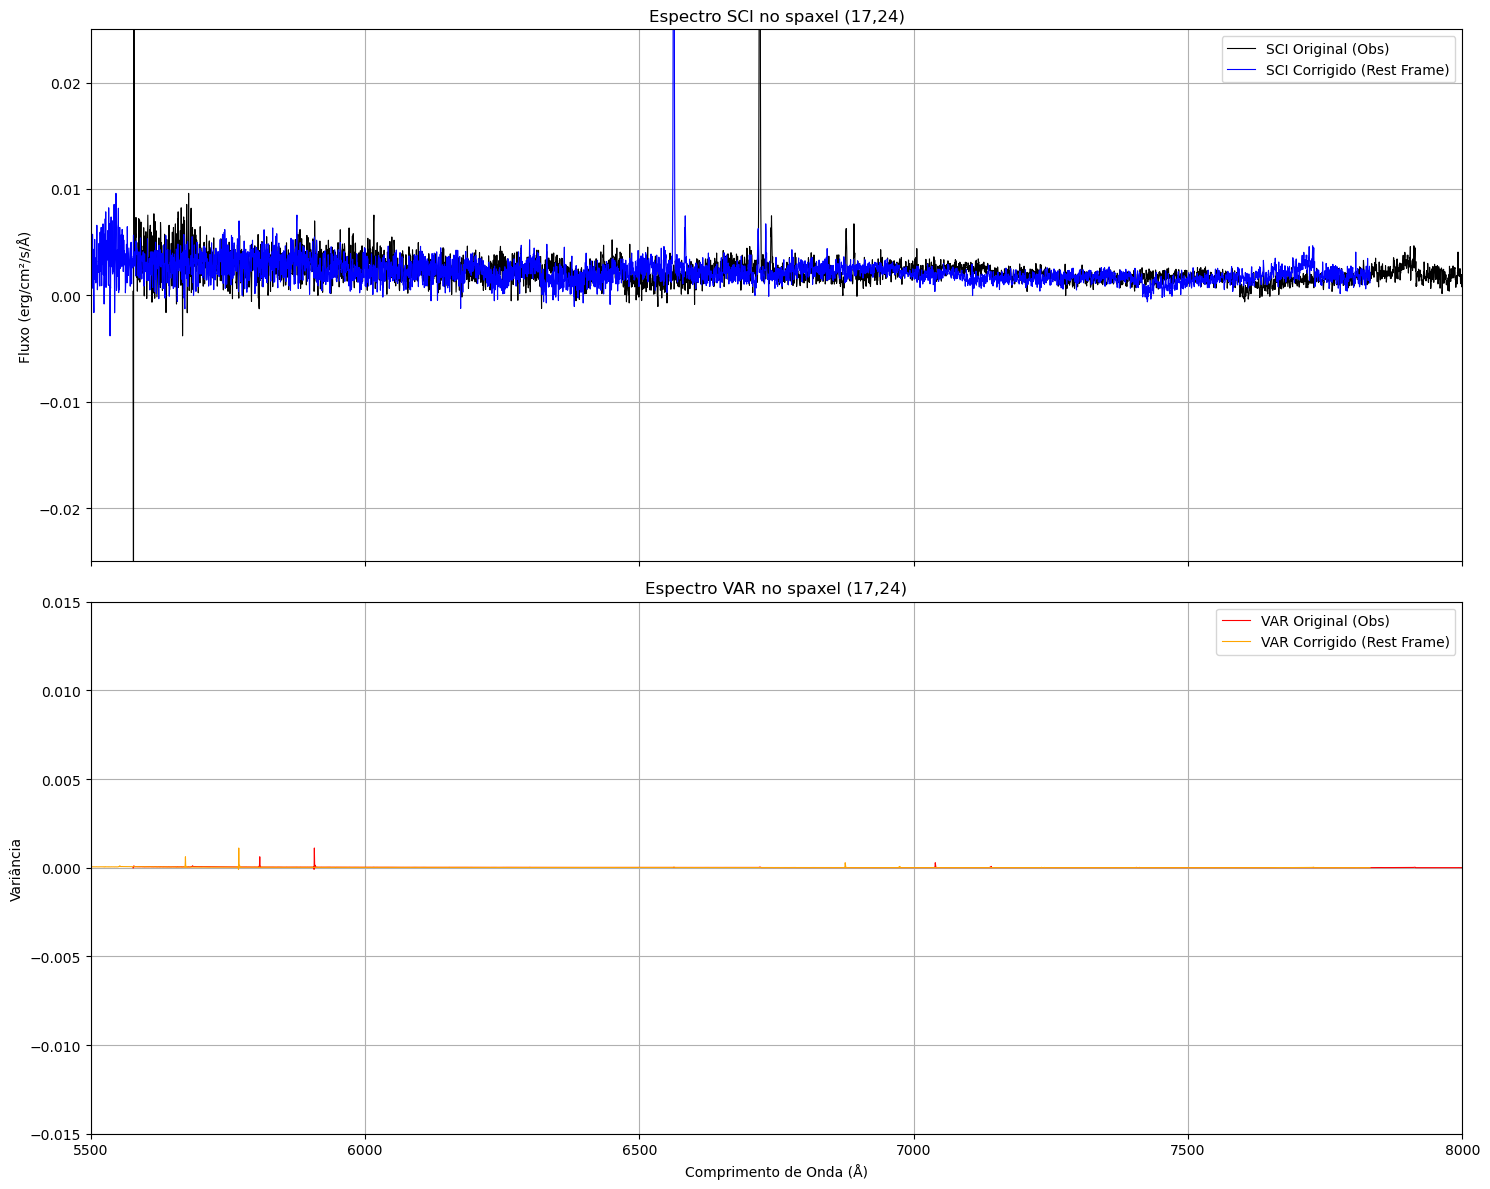

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- 1. Ler o cubo original (antes da correção) ---
orig_file = output_cubes + 'cubocombinado_extensoesR.fits'
hdul_orig = fits.open(orig_file)
header_orig = hdul_orig[0].header  
sci_orig = hdul_orig[0].data   # Extensão SCI original
var_orig = hdul_orig[1].data   # Extensão VAR original
hdul_orig.close()

lambda_start_orig = header_orig['CRVAL3']
delta_lambda_orig = header_orig['CDELT3']
z_dim, y_dim, x_dim = sci_orig.shape
wavelengths_obs = lambda_start_orig + delta_lambda_orig * np.arange(z_dim)

# --- 2. Ler o cubo corrigido (rest frame) ---
rest_file = output_cubes + 'restframeR.fits'
hdul_corr = fits.open(rest_file)
header_corr = hdul_corr[0].header  
sci_corr = hdul_corr[0].data   # Extensão SCI corrigida
var_corr = hdul_corr[1].data    # Extensão VAR corrigida
hdul_corr.close()

lambda_start_corr = header_corr['CRVAL3']
delta_lambda_corr = header_corr['CDELT3']
z_dim_corr, _, _ = sci_corr.shape
wavelengths_corr = lambda_start_corr + delta_lambda_corr * np.arange(z_dim_corr)

# --- 3. Selecionar um spaxel específico (ex: x = 20, y = 15) ---
x, y = 17, 24

# Extraindo o espectro (SCI) e a variância (VAR) para o spaxel escolhido:
spec_orig_sci = sci_orig[:, y, x]
var_spec_orig = var_orig[:, y, x]

spec_corr_sci = sci_corr[:, y, x]
var_spec_corr = var_corr[:, y, x]

# Se no seu código original você aplicava um fator de escala (por exemplo, multiplicava por 20000 para melhor visualização do SCI)

spec_orig_plot =  spec_orig_sci
spec_corr_plot =  spec_corr_sci

# --- 4. Plotar os espectros para comparação visual ---
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot para a extensão SCI:
axs[0].plot(wavelengths_obs, spec_orig_plot, color='black', lw=0.8, label='SCI Original (Obs)')
axs[0].plot(wavelengths_corr, spec_corr_plot, color='blue', lw=0.8, label='SCI Corrigido (Rest Frame)')
axs[0].set_ylabel('Fluxo (erg/cm²/s/Å)')
axs[0].set_title(f'Espectro SCI no spaxel ({x},{y})')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim(5500, 8000)
axs[0].set_ylim(-0.025,0.025)

# Plot para a extensão VAR:
axs[1].plot(wavelengths_obs, var_spec_orig, color='red', lw=0.8, label='VAR Original (Obs)')
axs[1].plot(wavelengths_corr, var_spec_corr, color='orange', lw=0.8, label='VAR Corrigido (Rest Frame)')
axs[1].set_xlabel('Comprimento de Onda (Å)')
axs[1].set_ylabel('Variância')
axs[1].set_title(f'Espectro VAR no spaxel ({x},{y})')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlim(5500, 8000)
axs[1].set_ylim(-0.015,0.015)

plt.tight_layout()
plt.show()


In [ ]:
# BLUE
hdul = fits.open(output_cubes+'restframeB.fits')
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) # Fluxos na extensão SCI
var_array = np.array(var_data) # Fluxos na extensão VAR
z_dim, y_dim, x_dim = sci_array.shape
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)

mask_intervals_sci = [
    (3819,3824),
    (3841,3847),
    (3875,3884),
    (3916,3924),
    (3954,3962),
    (3967,3976), #Hep
    (3986,3991),
    (4012,4019),
    (4055,4058),
    (4099,4103),
    (4110,4121),
    (4169,4175), 
    (4195,4200),
    (4257,4260),
    (4279,4284),
    (4338,4339),
    (4418,4421),
    (4534,4541),
    (4550,4552),
    (4664,4674),
    (4731,4737),
    (4942,4947),
    (4963,4985),
    (5028,5032),
    (5128,5131),
    (5247,5251),
    (5267,5325),
    (5327,5330),
    (5445,5455),
    (5466,5516),
    (5522,5525),
    (5529,5535),
    (5538,5547),
    (5560,5563),
    (5569,5572),
    (5578,5586),
    (5597,5625),
    (5627,5645),
    (5522,5525),
    (5529,5535),
    (5538,5547),
    (5560,5563),
    (5569,5572),
    (5578,5586),
    (5597,5625),
    (5627,5645),
    (5652,5668),
    (5722,5738),
    (5761,5767),
    (5788,5792),
    (5824,5828),
    (5886,5891),
    (5891,5995),
    (5899,5903),
    (5954,5956),
    (5969,5976),
    (5989,5996),
    (6012,6017),
    (6036,6047),
    (6078,6083),
    (6085,6117),
    (6133,6136),
    (6138,6141),
    (6144,6151),
    (6173,6182),
    (6186,6228),
    (6298,6305), #OI
    (6325,6333),
    (6337,6342),
    (6391,6395),
    (6403,6408),
    (6423,6426),
    (6461,6528),
    
]

mask_intervals_var=[
    (3968,3975),
    (4316,4327),
    (4423,4437),
    (4524,4535),
    (4614,4626),
    (4667,4671),
    (4970,4979),
    (5043,5060),
    (5151,5209),
    (5254,5273),
    (5344,5361),
]

# Aplica a interpolação para a extensão SCI:
for lambda_min_mask, lambda_max_mask in mask_intervals_sci:
    index_min_mask = np.searchsorted(wavelengths, lambda_min_mask)
    index_max_mask = np.searchsorted(wavelengths, lambda_max_mask)
    for y in range(y_dim):
        for x in range(x_dim):
            spectrum = sci_array[:, y, x]
            valid_indices = np.ones_like(spectrum, dtype=bool)
            valid_indices[index_min_mask:index_max_mask] = False
            if np.sum(valid_indices) > 1:
                interp_func = interp1d(wavelengths[valid_indices], spectrum[valid_indices],
                                       kind='linear', bounds_error=False, fill_value="extrapolate")
                sci_array[index_min_mask:index_max_mask, y, x] = interp_func(wavelengths[index_min_mask:index_max_mask])

# Aplica a interpolação para a extensão VAR:
for lambda_min_mask, lambda_max_mask in mask_intervals_var:
    index_min_mask = np.searchsorted(wavelengths, lambda_min_mask)
    index_max_mask = np.searchsorted(wavelengths, lambda_max_mask)
    for y in range(y_dim):
        for x in range(x_dim):
            spectrum = var_array[:, y, x]
            valid_indices = np.ones_like(spectrum, dtype=bool)
            valid_indices[index_min_mask:index_max_mask] = False
            if np.sum(valid_indices) > 1:
                interp_func = interp1d(wavelengths[valid_indices], spectrum[valid_indices],
                                       kind='linear', bounds_error=False, fill_value="extrapolate")
                var_array[index_min_mask:index_max_mask, y, x] = interp_func(wavelengths[index_min_mask:index_max_mask])

# Cria o novo arquivo FITS com as duas extensões:
hdu_primary = fits.PrimaryHDU(sci_array, header=header)
hdu_var = fits.ImageHDU(var_array, header=header, name='VAR')
hdul_new = fits.HDUList([hdu_primary, hdu_var])
hdul_new.writeto(output_cubes+'maskedB.fits', overwrite=True)



[5446.76603226 5447.25690239 5447.74777251 ... 7830.92223275 7831.41310288
 7831.903973  ]


In [46]:
#RED
hdul = fits.open(output_cubes+'restframeR.fits')
header = hdul[0].header  
sci_data = hdul[0].data  # SCI
var_data = hdul[1].data  # VAR
hdul.close()
lambda_start = header['CRVAL3']
delta_lambda = header['CDELT3']
sci_array = np.array(sci_data) # Fluxos na extensão SCI
var_array = np.array(var_data) # Fluxos na extensão VAR
z_dim, y_dim, x_dim = sci_array.shape
wavelengths = lambda_start + delta_lambda * np.arange(z_dim)
print(wavelengths)

mask_intervals_sci = [
    (5447,5462),
    (5569,5573),
    (5601,5610),
    (5616,5644),
    (5652,5667),
    (5673,5678),
    (5694,5700),
    (5762,5776),
    (5788,5792),
    (5815,5820),
    (5885,5893),
    (5898,5903),
    (5923,5926),
    (5988,5995),
    (6024,6031),
    (6137,6142),
    (6186,6224),
    (6228,6233),
    (6297,6303),
    (6325,6331),
    (6402,6408),
    (6422,6425),
    (6468,6472),
    (6497,6502),
    (6558,6560),
    (6623,6630),
    (6637,6640),
    (6732,6737),
    (6777,6785),
    (6813,6821),
    (6844,6850),
    (6874,6882),
    (6975,6980),
    (6999,7009),
    (7010,7014),
    (7023,7028),
    (7040,7049),
    (7104,7112),
    (7170,7175),
    (7185,7194),
    (7195,7200),
    (7217,7224),
    (7249,7254),
    (7272,7280),
    (7318,7323),
    (7325,7333),
    (7358,7369),
    (7374,7378),
    (7435,7451),
    (7460,7468),
    (7538,7543),
    (7545,7549),
    (7554,7566),
    (7568,7576),
    (7581,7586),
    (7613,7622),
    (7629,7634),
    (7634,7641),
    (7644,7652),
    (7726,7735),
    (7780,7788),
    (7797,7802),
    (7807,7811),
    (7812,7815),
    (7828,7831),

]

mask_intervals_var=[
    (5447,5454),
    (5457,5468),
    (5488,5490),
    (5495,5503),
    (5549,5555),
    (5666,5682),
    (5707,5713),
    (5762,5780),
    (6181,6220),
    (6283,6319),
    (6324,6338),
    (6422,6438),
    (6865,6887),
    (6964,6987),
    (7203,7211),
    (7274,7281),
    (7443,7452),
    (7527,7533),
    (7684,7695),
    (7696,7699),
    (7702,7706),
    (7785,7792),
    (7800,7805),

]
# Aplica a interpolação para a extensão SCI:
for lambda_min_mask, lambda_max_mask in mask_intervals_sci:
    index_min_mask = np.searchsorted(wavelengths, lambda_min_mask)
    index_max_mask = np.searchsorted(wavelengths, lambda_max_mask)
    for y in range(y_dim):
        for x in range(x_dim):
            spectrum = sci_array[:, y, x]
            valid_indices = np.ones_like(spectrum, dtype=bool)
            valid_indices[index_min_mask:index_max_mask] = False
            if np.sum(valid_indices) > 1:
                interp_func = interp1d(wavelengths[valid_indices], spectrum[valid_indices],
                                       kind='linear', bounds_error=False, fill_value="extrapolate")
                sci_array[index_min_mask:index_max_mask, y, x] = interp_func(wavelengths[index_min_mask:index_max_mask])

# Aplica a interpolação para a extensão VAR:
for lambda_min_mask, lambda_max_mask in mask_intervals_var:
    index_min_mask = np.searchsorted(wavelengths, lambda_min_mask)
    index_max_mask = np.searchsorted(wavelengths, lambda_max_mask)
    for y in range(y_dim):
        for x in range(x_dim):
            spectrum = var_array[:, y, x]
            valid_indices = np.ones_like(spectrum, dtype=bool)
            valid_indices[index_min_mask:index_max_mask] = False
            if np.sum(valid_indices) > 1:
                interp_func = interp1d(wavelengths[valid_indices], spectrum[valid_indices],
                                       kind='linear', bounds_error=False, fill_value="extrapolate")
                var_array[index_min_mask:index_max_mask, y, x] = interp_func(wavelengths[index_min_mask:index_max_mask])

# Cria o novo arquivo FITS com as duas extensões:
hdu_primary = fits.PrimaryHDU(sci_array, header=header)
hdu_var = fits.ImageHDU(var_array, header=header, name='VAR')
hdul_new = fits.HDUList([hdu_primary, hdu_var])
hdul_new.writeto(output_cubes+'maskedR.fits', overwrite=True)



[5446.76603226 5447.25690239 5447.74777251 ... 7830.92223275 7831.41310288
 7831.903973  ]
